In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil


from glob import glob
from tqdm import tqdm

In [ ]:
!rm -r dataset
!unzip /content/drive/MyDrive/miniProject/benetech-making-graphs-accessible.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/images/eaed09039206.jpg  
  inflating: dataset/train/images/eaed1e245167.jpg  
  inflating: dataset/train/images/eaedb251e670.jpg  
  inflating: dataset/train/images/eaeead418936.jpg  
  inflating: dataset/train/images/eaeeb1c2ecdd.jpg  
  inflating: dataset/train/images/eaef70ba842d.jpg  
  inflating: dataset/train/images/eaf036991cb3.jpg  
  inflating: dataset/train/images/eaf06e9e07db.jpg  
  inflating: dataset/train/images/eaf20f7d8945.jpg  
  inflating: dataset/train/images/eaf3a9a87868.jpg  
  inflating: dataset/train/images/eaf3d05d20a6.jpg  
  inflating: dataset/train/images/eaf3d24fb032.jpg  
  inflating: dataset/train/images/eaf3f734b5ce.jpg  
  inflating: dataset/train/images/eaf467f871a2.jpg  
  inflating: dataset/train/images/eaf65b4e3c45.jpg  
  inflating: dataset/train/images/eaf7f876411a.jpg  
  inflating: dataset/train/images/eafa35356cf8.jpg  
  inflating: dataset/train/images/eafa65caf8e7.j

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15831, done.
remote: Total 15831 (delta 0), reused 0 (delta 0), pack-reused 15831
Receiving objects: 100% (15831/15831), 14.42 MiB | 30.26 MiB/s, done.
Resolving deltas: 100% (10874/10874), done.


In [ ]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.7/592.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


**Import Library**

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
def extract_plot_bb(data,image = "None"):
    w = data["plot-bb"]["width"]
    h = data["plot-bb"]["height"]
    x0 = data["plot-bb"]["x0"] + w/2
    y0 = data["plot-bb"]["y0"] + h/2
    image_w,image_h,c = image.shape
    x0 = x0/image_h
    y0 = y0/image_w
    w = w/image_h
    h = h/image_w

    return [x0, y0, w, h, "plot-bb"]



def extract_label_bbox(data, rows, img_id,image = "None"):
    common = []
    if data["chart-type"] != 'scatter':
      return None
    common+= [img_id, data["source"], data["chart-type"]]
    # TRAIN_FOLDER = "/content/dataset/train/images/"
    # image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
    image_w,image_h,c = image.shape
    # print(image_w,image_h)
    for box in data["text"]:
        # x0 = box["polygon"]["x0"]
        # y0 = box["polygon"]["y1"]
        # w = abs(box["polygon"]["x1"] - box["polygon"]["x0"]) + abs(box["polygon"]["x2"] - box["polygon"]["x1"])
        # h = abs(box["polygon"]["y3"] - box["polygon"]["y1"])
        # x0 = box["polygon"]["x0"]
        # y0 = box["polygon"]["y0"]
        # w = box["polygon"]["x1"] - box["polygon"]["x0"]
        # h = box["polygon"]["y3"] - box["polygon"]["y0"]
        # print(box["polygon"]["x2"],box["polygon"]["x0"],box["polygon"]["y2"],box["polygon"]["y0"])
        x0 = (box["polygon"]["x0"] + box["polygon"]["x2"])/2
        y0 = (box["polygon"]["y0"] + box["polygon"]["y2"])/2
        w = box["polygon"]["x2"] - box["polygon"]["x0"]
        h = box["polygon"]["y3"] - box["polygon"]["y0"]
        x0 = x0/image_h
        y0 = y0/image_w
        w = w/image_h
        h = h/image_w

        label = box["role"]
        # print(label)
        box_row = common + [x0, y0, w, h, label]
        rows.append(box_row)
    rows.append(common + extract_plot_bb(data,image)) 
    return rows
        
def extract_tick_bbox(data, rows, img_id,image = "None"):
    common = []
    common+= [img_id , data["source"], data["chart-type"]]
    # TRAIN_FOLDER = "/content/dataset/train/images/"
    # image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
    image_w,image_h,c = image.shape
    for axis in data["axes"].keys():
        for box in data["axes"][axis]["ticks"]:
            w = 5
            h = 5
            x0 = box["tick_pt"]["x"]
            y0 = box["tick_pt"]["y"]

            x0 = x0/image_h
            y0 = y0/image_w
            w = w/image_h
            h = h/image_w

            label = axis + "-tick"
            box_row = common + [x0, y0, w, h,label]
            rows.append(box_row)

    for axis in data["visual-elements"]["scatter points"]:
        for box in axis:
            w = 10
            h = 10
            x0 = box["x"]
            y0 = box["y"]

            x0 = x0/image_h
            y0 = y0/image_w
            w = w/image_h
            h = h/image_w

            label = "visual-point"
            box_row = common + [x0, y0, w, h,label]
            rows.append(box_row)

    return rows

In [ ]:
from pathlib import Path

def is_nan(value):
     return isinstance(value, float) and str(value) == "nan"

def round_float(value):
    if isinstance(value, float):
        value = str(value)

        if "." in value:
            integer, decimal = value.split(".")
            if abs(float(integer)) > 1:
                decimal = decimal[:1]
            else:
                decimal = decimal[:4]

            value = integer + "." + decimal
    return value

def get_gt_string_and_xy(filepath):
    filepath = Path(filepath)

    with open(filepath) as fp:
        data = json.load(fp)
    if data['chart-type'] in ['horizontal_bar','vertical_bar','dot','line']:
       return None

    data_series = data["data-series"]

    all_x, all_y = [], []

    for d in data_series:
        x = d["x"]
        y = d["y"]

        x = round_float(x)
        y = round_float(y)

        # Ignore nan values
        if is_nan(x) or is_nan(y):
            continue

        all_x.append(x)
        all_y.append(y)
        
    

    return pd.DataFrame({
        "x": all_x,
        "y": all_y,
    })

In [ ]:
get_gt_string_and_xy('/content/dataset/train/annotations/005559e9d574.json')

,x,y
0,1990.0,298.9
1,1991.0,291.4
2,1991.9,293.9
3,1993.0,309.0
4,1994.0,321.7
5,1995.0,336.8
6,1995.9,352.0
7,1996.9,379.7
8,1998.0,374.7
9,1998.9,415.1


In [ ]:
ANNOTATION = "/content/dataset/train/annotations/*.json"
TRAIN_FOLDER = "/content/dataset/train/images/"
rows = []
for file_name in tqdm(glob(ANNOTATION)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        image = cv2.imread(TRAIN_FOLDER + img_id + ".jpg")
        label_bbox = extract_label_bbox(data, label_bbox, img_id,image)
        if label_bbox == None:
           continue
        tick_bbox = extract_tick_bbox(data, tick_bbox, img_id,image)
        # print(label_bbox)
        # print(tick_bbox)
        data_rows = label_bbox + tick_bbox
    rows += data_rows
    # break

100%|██████████| 60578/60578 [02:11<00:00, 460.24it/s]


In [ ]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "x0", "y0", "w", "h", "label"]
df.head()

,image_id,source,chart,x0,y0,w,h,label
0,502feb38bbdd,generated,scatter,0.581169,0.041045,0.794372,0.067164,chart_title
1,502feb38bbdd,generated,scatter,0.029221,0.550373,0.028139,0.809701,axis_title
2,502feb38bbdd,generated,scatter,0.566017,0.942164,0.067100,0.041045,axis_title
3,502feb38bbdd,generated,scatter,0.104978,0.139925,0.110390,0.041045,tick_label
4,502feb38bbdd,generated,scatter,0.106061,0.216418,0.108225,0.044776,tick_label


In [ ]:
def get_stoi(df):
    """Get String to Index dictionary"""
    stoi = {}
    for idx, string in enumerate(df.label.unique()):
        stoi[string] = idx
    itos = {item[1]: item[0] for item in stoi.items()}
    df = df.replace({"label": stoi})
    return stoi

stoi = get_stoi(df)
print(stoi)
NUM_CLASSES =  len(stoi)
df = df[df["label"].isin(list(stoi.keys()))]
df = df.replace({"label": stoi})

{'chart_title': 0, 'axis_title': 1, 'tick_label': 2, 'plot-bb': 3, 'x-axis-tick': 4, 'y-axis-tick': 5, 'visual-point': 6, 'tick_grouping': 7, 'other': 8}


In [ ]:
def get_new_annotation(df):
    for tup in df.groupby("image_id"):
        name = tup[0]
        x = []
        y = []
        w = []
        h = []
        label = []
        for ele in tup:
          try:
            x = ele['x0'].to_list()
            y = ele['y0'].to_list()
            w = ele['w'].to_list()
            h = ele['h'].to_list()
            label = ele['label'].to_list()
          except:
            continue
        with open('new_annotation/{}.txt'.format(name),'a') as f:
            for i in range(len(x)):
                f.write("{} {} {} {} {}\n".format(label[i],x[i],y[i],w[i],h[i]))

In [ ]:
!rm -r new_annotation
!mkdir new_annotation
get_new_annotation(df)

rm: cannot remove 'new_annotation': No such file or directory


In [ ]:
annotations = [os.path.join('new_annotation', x) for x in os.listdir('new_annotation') if x[-3:] == "txt"]

[['0', '0.5159045725646123', '0.0688622754491018', '0.7296222664015904', '0.04790419161676647'], ['1', '0.03479125248508946', '0.4880239520958084', '0.02584493041749503', '0.8083832335329342'], ['1', '0.5675944333996024', '0.9446107784431138', '0.6262425447316103', '0.04491017964071856'], ['2', '0.16500994035785288', '0.8802395209580839', '0.019880715705765408', '0.041916167664670656'], ['2', '0.24453280318091453', '0.8802395209580839', '0.019880715705765408', '0.041916167664670656'], ['2', '0.3260437375745527', '0.8802395209580839', '0.03180914512922465', '0.041916167664670656'], ['2', '0.40755467196819084', '0.8802395209580839', '0.03180914512922465', '0.041916167664670656'], ['2', '0.4870775347912525', '0.8802395209580839', '0.03578528827037773', '0.041916167664670656'], ['2', '0.5666003976143141', '0.8802395209580839', '0.03578528827037773', '0.041916167664670656'], ['2', '0.6481113320079522', '0.8802395209580839', '0.03578528827037773', '0.041916167664670656'], ['2', '0.7286282306

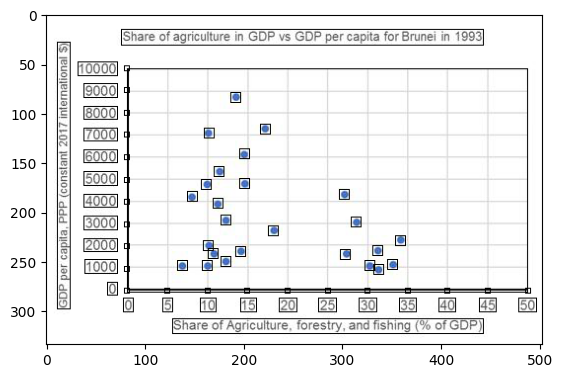

In [ ]:
# annotations = '/content/new_annotation/*'
import matplotlib.patches as patches
class_id_to_name_mapping = {v : k for k,v in stoi.items()}
# print(itos)
# fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (20,15)
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    print(w,h)
    # print(image.size)
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    # print(transformed_annotations)
    # print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        # obj_cls, x0, y0, w, h = int(ann[0]),int(ann[1]),int(ann[2]),int(ann[3]),int(ann[4])
        obj_cls, x0, y0, x1, y1 = ann
        # print(x0,y0,x1,y1)
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline = "black")
        # image_patch = np.array(image)[int(y0):int(y1),int(x0):int(x1)]
        # plt.imshow(image_patch)
        # print(class_id_to_name_mapping[(int(obj_cls))])
        # if class_id_to_name_mapping[(int(obj_cls))] in ["chart_title", "axis_title", "tick-label"]:
        #   print(image_patch.shape)
        #   extracted_text = text_reader.readtext(image_patch)[1]
        #   print(extracted_text)
        # plt.show()
        # plotted_image.point((x0,y0),fill='black')

        # plotted_image.text((x0, y0 + 10), class_id_to_name_mapping[(int(obj_cls))], (128, 255, 128))
        # print( class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# print(annotation_list)
#Get the corresponding image file
# print(annotation_file)
image_file = annotation_file.replace("new_annotation", "dataset/train/images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
images = [os.path.join('dataset/train/images', x.replace("txt","jpg")) for x in os.listdir('new_annotation') if x[-3:] == "txt"]
annotations = [os.path.join('new_annotation', x) for x in os.listdir('new_annotation') if x[-3:] == "txt"]
images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!rm -r chart2table
!mkdir chart2table
!mkdir chart2table/images
!mkdir chart2table/labels
!mkdir chart2table/images/train chart2table/images/val chart2table/images/test chart2table/labels/train chart2table/labels/val chart2table/labels/test

rm: cannot remove 'chart2table': No such file or directory


In [ ]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'chart2table/images/train')
move_files_to_folder(val_images, 'chart2table/images/val/')
move_files_to_folder(test_images, 'chart2table/images/test/')
move_files_to_folder(train_annotations, 'chart2table/labels/train/')
move_files_to_folder(val_annotations, 'chart2table/labels/val/')
move_files_to_folder(test_annotations, 'chart2table/labels/test/')

**Training**

In [ ]:
!rm -f /content/yolov5/data/chart.yaml
with open("/content/yolov5/data/chart.yaml","a") as f:
    f.write("train: /content/chart2table/images/train\n")
    f.write("val: /content/chart2table/images/val\n")
    f.write("test: /content/chart2table/images/test\n")
    f.write("nc: 9\n")
    f.write("names: ['chart_title','axis_title','tick_label','plot-bb','x-axis-tick','y-axis-tick','other','tick_grouping','legend_label']")

In [ ]:
# !python yolov5/train.py --img 640 --cfg yolov5/models/yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.scratch-high.yaml --batch 32 --epochs 100 --data yolov5/data/chart.yaml --weights best.pt --workers 24 --name train_chart_det
!python yolov5/train.py --img 640 --cfg yolov5/models/yolov5m.yaml --hyp /content/yolov5/data/hyps/hyp.no-augmentation.yaml --batch 32 --epochs 100 --data yolov5/data/chart.yaml  --weights /content/drive/MyDrive/miniProject/pretrain/best_5m.pt --workers 24 --name train_chart_det

train: weights=best.pt, cfg=yolov5/models/yolov5m.yaml, data=yolov5/data/chart.yaml, hyp=/content/yolov5/data/hyps/hyp.no-augmentation.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=train_chart_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, 

In [ ]:
!python yolov5/detect.py --source /content/chart2table/images/test --weights /content/drive/MyDrive/miniProject/pretrain/best_5m.pt --conf 0.25 --name yolo_test_det --save-txt

detect: weights=['/content/drive/MyDrive/miniProject/pretrain/best_5m.pt'], source=/content/chart2table/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_test_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20885262 parameters, 0 gradients, 48.0 GFLOPs
image 1/1125 /content/chart2table/images/test/003e81b2b2eb.jpg: 384x640 1 chart_title, 2 axis_titles, 17 tick_labels, 1 plot-bb, 7 x-axis-ticks, 8 y-axis-ticks, 23 others, 45.4ms
image 2/1125 /content/chart2table/images/test/005559e9d574.jpg: 384x640 1 chart_title, 2 axis_titles, 17

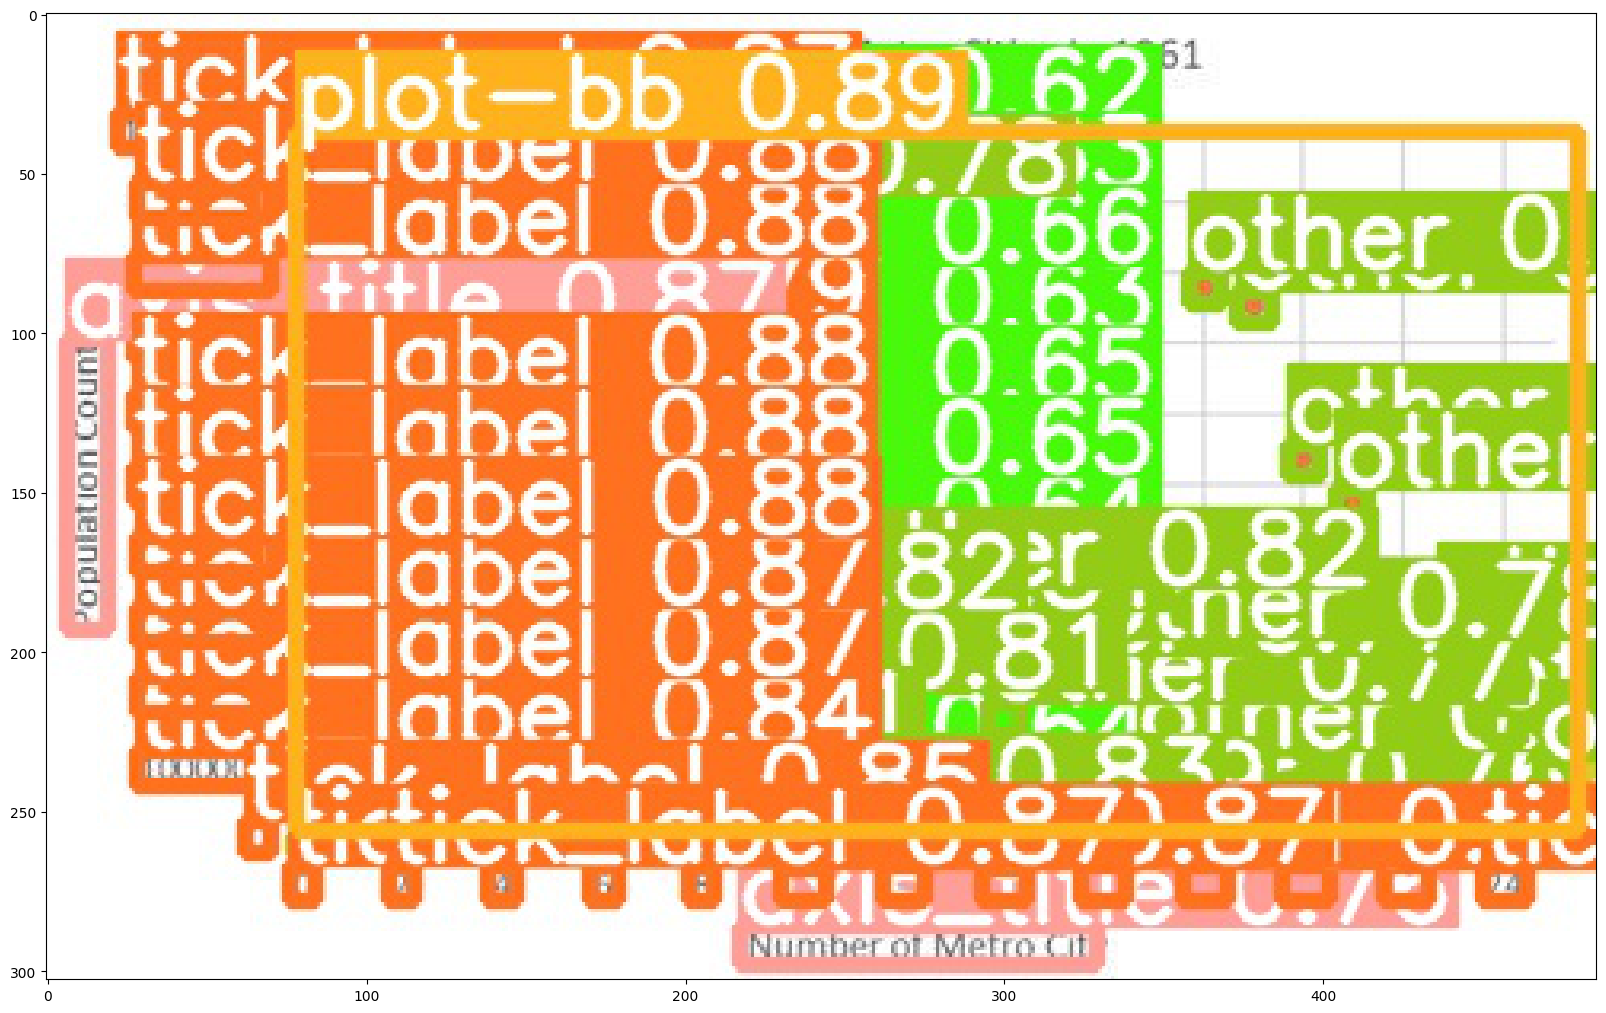

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
detections_dir = "/content/yolov5/runs/detect/yolo_test_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!python yolov5/val.py --weights /content/drive/MyDrive/miniProject/pretrain/best_5m.pt --data yolov5/data/chart.yaml --task test --name yolo_det

val: data=yolov5/data/chart.yaml, weights=['/content/drive/MyDrive/miniProject/pretrain/best_5m.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20885262 parameters, 0 gradients, 48.0 GFLOPs
100% 755k/755k [00:00<00:00, 41.5MB/s]
test: Scanning /content/chart2table/labels/test... 1125 images, 0 backgrounds, 1 corrupt: 100% 1125/1125 [00:00<00:00, 1544.81it/s]
test: WARNING ⚠️ /content/chart2table/images/test/3815716531dd.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1345]
test: New cache created: /content/chart2table/labels/test.cache
                 Class     

[['5', '0.0965447', '0.842561', '0.0101626', '0.017301'], ['4', '0.586382', '0.842561', '0.0101626', '0.017301'], ['4', '0.218496', '0.842561', '0.0101626', '0.017301'], ['4', '0.953252', '0.84083', '0.0121951', '0.0207612'], ['4', '0.341463', '0.842561', '0.0121951', '0.017301'], ['4', '0.70935', '0.842561', '0.0121951', '0.017301'], ['4', '0.832317', '0.84083', '0.0101626', '0.0207612'], ['4', '0.464431', '0.842561', '0.0101626', '0.017301'], ['5', '0.097561', '0.780277', '0.0121951', '0.017301'], ['5', '0.097561', '0.34083', '0.0121951', '0.017301'], ['5', '0.097561', '0.212803', '0.0121951', '0.017301'], ['5', '0.097561', '0.716263', '0.0121951', '0.0207612'], ['5', '0.097561', '0.467128', '0.0121951', '0.0207612'], ['5', '0.097561', '0.655709', '0.0121951', '0.017301'], ['5', '0.0965447', '0.276817', '0.0101626', '0.0207612'], ['5', '0.097561', '0.591695', '0.0121951', '0.0207612'], ['5', '0.0965447', '0.403114', '0.0101626', '0.017301'], ['5', '0.0965447', '0.527682', '0.0101626'

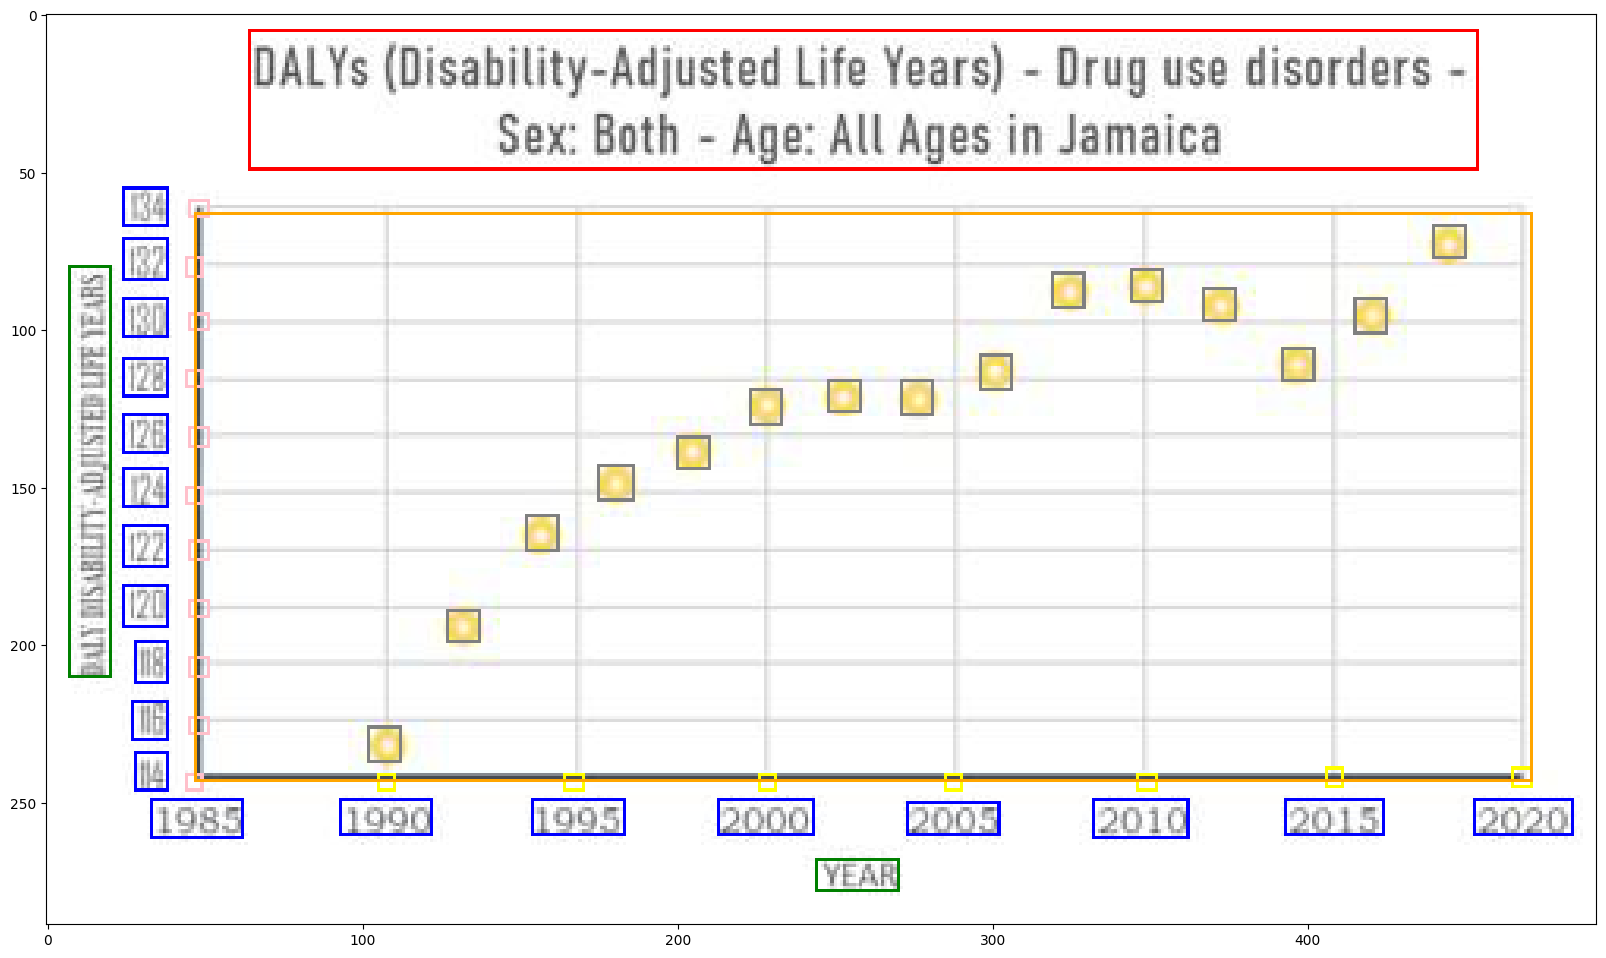

In [ ]:
# annotations = '/content/new_annotation/*'
import matplotlib.patches as patches
class_id_to_name_mapping = {v : k for k,v in stoi.items()}
# print(itos)
dict_color = {'chart_title' : 'red',
              'axis_title' : 'green',
              'tick_label' : 'blue',
              'plot-bb' : 'orange',
              'x-axis-tick' : 'yellow',
              'y-axis-tick' : 'pink',
              'visual-point' : 'gray',
              'other' : 'brown',
              'tick_grouping' : 'black'}
# fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (20,15)
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    # print(w,h)
    # print(image.size)
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    # print(transformed_annotations)
    # print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        # obj_cls, x0, y0, w, h = int(ann[0]),int(ann[1]),int(ann[2]),int(ann[3]),int(ann[4])
        obj_cls, x0, y0, x1, y1 = ann
        # print(class_id_to_name_mapping[obj_cls])
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline = dict_color[class_id_to_name_mapping[obj_cls]])
        # plotted_image.point((x0,y0),fill='black')
        # print(class_id_to_name_mapping[(int(obj_cls))])
        # if class_id_to_name_mapping[(int(obj_cls))] in ["chart_title", "axis_title", "tick_label"]:
        #   image_patch = np.array(image)[int(y0):int(y1),int(x0):int(x1)]
        #   plt.imshow(image_patch)
        #   print(image_patch.shape)
        #   extracted_text = text_reader.readtext(image_patch)
        #   for (bbox, text, prob) in extracted_text:
        #       print(text)
        #   # print(extracted_text)
        # plt.show()

        # plotted_image.text((x0, y0 + 10), class_id_to_name_mapping[(int(obj_cls))], (128, 255, 128))
        # print( class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice([os.path.join('/content/yolov5/runs/detect/yolo_test_det/labels', x) for x in os.listdir('/content/yolov5/runs/detect/yolo_test_det/labels') if x[-3:] == "txt"])
annotation_file = '/content/yolov5/runs/detect/yolo_test_det/labels/fc37f02296d6.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# print(annotation_list)
#Get the corresponding image file
# print(annotation_file)
image_file = annotation_file.replace("/content/yolov5/runs/detect/yolo_test_det/labels", "/content/chart2table/images/test").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

**Recognition**

In [ ]:
import locale 
print(locale.getdefaultlocale())
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

('en_US', 'UTF-8')
UTF-8


In [ ]:
!python yolov5/detect.py --source /content/dataset/test/images/00f5404753cf.jpg --weights /content/drive/MyDrive/miniProject/pretrain/best_5m.pt --conf 0.25 --name 00f5404753cf --save-txt

detect: weights=['/content/drive/MyDrive/miniProject/pretrain/best_5m.pt'], source=/content/dataset/test/images/00f5404753cf.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=00f5404753cf, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20885262 parameters, 0 gradients, 48.0 GFLOPs
image 1/1 /content/dataset/test/images/00f5404753cf.jpg: 480x640 4 axis_titles, 16 tick_labels, 1 plot-bb, 6 x-axis-ticks, 7 y-axis-ticks, 43 others, 43.3ms
Speed: 0.5ms pre-process, 43.3ms inference, 95.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5

In [ ]:
def module_bb(image_file):
    file_name = image_file.split('/')[-1].replace('.jpg','.txt')
    folder_name = file_name.split('.')[0]
    print(file_name)
    print(folder_name)
    annotation_file = f'yolov5/runs/detect/{folder_name}/labels/{file_name}'
    with open(annotation_file, "r") as file:
        annotation_list = file.read().split("\n")[:-1]
        annotation_list = [x.split(" ") for x in annotation_list]
        print(annotation_list)
        annotation_list = [[float(y) for y in x ] for x in annotation_list]
    
    image = Image.open(image_file)

    w, h = image.size

    annotations = np.array(annotation_list)
    transformed_annotations = np.copy(annotations)

    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    dict_res = defaultdict(list)

    for ele_lst in transformed_annotations:
        label = class_id_to_name_mapping[ele_lst[0]]
        coord = ele_lst[1:]
        dict_res[label].append(coord)
    
    return dict_res

In [ ]:
from collections import defaultdict

module_bb('/content/dataset/test/images/00f5404753cf.jpg')

In [ ]:
annotation_file = random.choice([os.path.join('/content/yolov5/runs/detect/yolo_test_det/labels', x) for x in os.listdir('/content/yolov5/runs/detect/yolo_test_det/labels') if x[-3:] == "txt"])
annotation_file = '/content/yolov5/runs/detect/yolo_test_det/labels/46f32c46d07f.txt'
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

image_file = annotation_file.replace("/content/yolov5/runs/detect/yolo_test_det/labels", "/content/chart2table/images/test").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

w, h = image.size

annotations = np.array(annotation_list)
transformed_annotations = np.copy(annotations)

transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 

transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

[['4', '0.105096', '0.822993', '0.0106157', '0.0182482'], ['1', '0.531847', '0.877737', '0.0615711', '0.0474453'], ['4', '0.960722', '0.822993', '0.0106157', '0.0182482'], ['4', '0.211253', '0.822993', '0.0106157', '0.0182482'], ['4', '0.748408', '0.822993', '0.0106157', '0.0182482'], ['4', '0.318471', '0.822993', '0.00849257', '0.0182482'], ['5', '0.105096', '0.75', '0.0106157', '0.0182482'], ['4', '0.53397', '0.822993', '0.0106157', '0.0182482'], ['4', '0.427813', '0.822993', '0.0106157', '0.0182482'], ['4', '0.854565', '0.822993', '0.0106157', '0.0182482'], ['5', '0.105096', '0.25', '0.0106157', '0.0182482'], ['5', '0.105096', '0.322993', '0.0106157', '0.0182482'], ['5', '0.106157', '0.678832', '0.0127389', '0.0218978'], ['5', '0.105096', '0.538321', '0.0106157', '0.0182482'], ['4', '0.640127', '0.822993', '0.0106157', '0.0182482'], ['5', '0.105096', '0.465328', '0.0106157', '0.0182482'], ['5', '0.105096', '0.607664', '0.0106157', '0.0182482'], ['5', '0.105096', '0.394161', '0.01061

In [ ]:
from collections import defaultdict
  

dict_res = defaultdict(list)

In [ ]:
for ele_lst in transformed_annotations:
    label = class_id_to_name_mapping[ele_lst[0]]
    coord = ele_lst[1:]
    dict_res[label].append(coord)

In [ ]:
#{'chart_title': 0, 'axis_title': 1, 'tick_label': 2, 'plot-bb': 3, 'x-axis-tick': 4, 'y-axis-tick': 5, 'visual-point': 6, 'tick_grouping': 7, 'other': 8}

In [ ]:
dict_res

In [ ]:
lm_x = np.mean([ele[3] for ele in dict_res['x-axis-tick']])
lm_y = np.mean([ele[0] for ele in dict_res['y-axis-tick']])
print(lm_y,lm_x)

47.000183324999995 228.0000854


In [ ]:
x_label = []
y_label = []

for tick_bb in dict_res['tick_label']:
    if tick_bb[2] < lm_y:
      if tick_bb[1] > lm_x:
          x_label.append(tick_bb)
      else:
          y_label.append(tick_bb)
      continue
    if tick_bb[1] > lm_x:
      x_label.append(tick_bb)

print(len(x_label))
print(len(y_label))
print(len(dict_res['tick_label']))
print(len(dict_res['x-axis-tick']) + len(dict_res['y-axis-tick']))

9
9
18
17


In [ ]:
x_label = sorted(x_label,key = lambda x : x[0] * x[1])
y_label = sorted(y_label,key = lambda x : x[2] * x[3])

In [ ]:
x_tick = sorted(dict_res['x-axis-tick'],key = lambda x : x[0] * x[1])

In [ ]:
y_tick = sorted(dict_res['y-axis-tick'],key = lambda x : x[2] * x[3])

In [ ]:
if len(x_tick) == len(y_tick) + 1:
   y_tick.append(x_tick[0])
elif len(x_tick)  == len(y_tick) - 1:
   x_tick = [y_tick[-1]] + x_tick 

In [ ]:
y_tick

[array([47.00021865, 65.9999966 , 52.00021335, 71.0000034 ]),
 array([47.00021865, 86.0000786 , 52.00021335, 91.0000854 ]),
 array([ 47.00021865, 105.0001154 ,  52.00021335, 111.0001126 ]),
 array([ 47.00021865, 124.9998686 ,  52.00021335, 129.9998754 ]),
 array([ 47.00021865, 144.9999506 ,  52.00021335, 149.9999574 ]),
 array([ 47.00021865, 163.9999326 ,  52.00021335, 168.9999394 ]),
 array([ 46.99993605, 182.9999694 ,  52.99995795, 188.9999666 ]),
 array([ 47.00021865, 202.9999966 ,  52.00021335, 208.0000034 ]),
 array([ 47.00021865, 223.0000786 ,  52.00021335, 228.0000854 ])]

In [ ]:
x_label

[array([ 36.99994665, 233.00001   ,  62.99994735, 244.000014  ]),
 array([ 86.99989365, 233.00001   , 112.99989435, 244.000014  ]),
 array([138.0000327, 233.00001  , 163.0000533, 244.000014 ]),
 array([188.00019165, 233.00001   , 214.00019235, 244.000014  ]),
 array([238.00013865, 233.00001   , 264.00013935, 244.000014  ]),
 array([288.00008565, 233.00001   , 314.00008635, 244.000014  ]),
 array([338.00003265, 233.00001   , 364.00003335, 244.000014  ]),
 array([389.0001717, 233.00001  , 414.0001923, 244.000014 ]),
 array([439.0001187, 233.00001  , 464.0001393, 244.000014 ])]

In [ ]:
x_tick

[array([ 47.00021865, 223.0000786 ,  52.00021335, 228.0000854 ]),
 array([ 97.00016565, 223.0000786 , 102.00016035, 228.0000854 ]),
 array([147.99984077, 223.0000786 , 151.99984124, 228.0000854 ]),
 array([198.99992565, 223.0000786 , 203.99992035, 228.0000854 ]),
 array([248.99987265, 223.0000786 , 253.99986735, 228.0000854 ]),
 array([298.99981965, 223.0000786 , 303.99981435, 228.0000854 ]),
 array([350.00017065, 223.0000786 , 355.00016535, 228.0000854 ]),
 array([400.00011765, 223.0000786 , 405.00011235, 228.0000854 ]),
 array([450.00006465, 223.0000786 , 455.00005935, 228.0000854 ])]

In [ ]:
y_label

[array([20.0000259, 61.999898 , 40.0000047, 72.999902 ]),
 array([20.0000259, 81.99998  , 40.0000047, 92.999984 ]),
 array([ 20.99998245, 102.0000209 ,  39.99998115, 112.0000071 ]),
 array([ 20.99998245, 121.000044  ,  39.99998115, 132.000048  ]),
 array([ 26.0000007, 140.000026 ,  40.0000047, 151.00003  ]),
 array([ 24.99999705, 159.000008  ,  39.99998115, 170.000012  ]),
 array([ 24.99999705, 179.00009   ,  39.99998115, 190.000094  ]),
 array([ 26.0000007, 198.000072 ,  40.0000047, 209.000076 ]),
 array([ 30.99997185, 217.99988   ,  39.99998115, 228.999884  ])]

**Get Text to Inference**

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
from PIL import Image

**Load model and processor**

In [ ]:
processor = DonutProcessor.from_pretrained("hoangphu7122002ai/donutAxis_v1")
model = VisionEncoderDecoderModel.from_pretrained("hoangphu7122002ai/donutAxis_v1")

In [ ]:
image = Image.open('/content/chart2table/images/test/fc37f02296d6.jpg')

In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 560, 560])


In [ ]:
import torch

task_prompt = "<|PROMPT|>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.decode([model.config.decoder_end_token_id]), "").replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
sequence = re.sub(r"<one>", "1", sequence)
sequence = re.sub(r"(?:(?<=>) | (?=</s_))", "", sequence)
sequence = sequence.split('<tick_label_y_end>')[0] + '<tick_label_y_end>'
print(sequence)

<|PROMPT|><chart_title_start>DALYs (Disability-Adjusted Life Years) - Drug use disorders - Sex: Both - Age: All Ages in Jamaica<chart_title_end><axis_title_x_start>YEAR<axis_title_x_end><axis_title_y_start>DAILY DISABILITY-ADJUSTED LIFE YEARS<axis_title_y_end><tick_label_x_start>1985;1990;1995;2000;2005;2010;2015;2020<tick_label_x_end><tick_label_y_start>134;132;130;128;126;124;122;120;118;116;114<tick_label_y_end>


In [ ]:
sequence

'<|PROMPT|><chart_title_start>DALYs (Disability-Adjusted Life Years) - Drug use disorders - Sex: Both - Age: All Ages in Jamaica<chart_title_end><axis_title_x_start>YEAR<axis_title_x_end><axis_title_y_start>DAILY DISABILITY-ADJUSTED LIFE YEARS<axis_title_y_end><tick_label_x_start>1985;1990;1995;2000;2005;2010;2015;2020<tick_label_x_end><tick_label_y_start>134;132;130;128;126;124;122;120;118;116;114<tick_label_y_end>'

In [ ]:
x_tick_label_mark = sequence.split('<tick_label_x_start>')[1].split('<tick_label_x_end>')[0].split(";")
y_tick_label_mark = sequence.split('<tick_label_y_start>')[1].split('<tick_label_y_end>')[0].split(";")
chart_title_mark = sequence.split('<chart_title_start>')[1].split('<chart_title_end>')[0].split(";")
x_axis_title_mark = sequence.split('<axis_title_x_start>')[1].split('<axis_title_x_end>')[0].split(";")
y_axis_title_mark = sequence.split('<axis_title_y_start>')[1].split('<axis_title_y_end>')[0].split(";")

In [ ]:
y_axis_title_mark

['DAILY DISABILITY-ADJUSTED LIFE YEARS']

In [ ]:
y_tick_label_mark

['134', '132', '130', '128', '126', '124', '122', '120', '118', '116', '114']

In [ ]:
def module_text(image_path):
    image = Image.open(image_path)
    pixel_values = processor(image, return_tensors="pt").pixel_values

    task_prompt = "<|PROMPT|>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    outputs = model.generate(pixel_values.to(device),
                                  decoder_input_ids=decoder_input_ids.to(device),
                                  max_length=model.decoder.config.max_position_embeddings,
                                  early_stopping=True,
                                  pad_token_id=processor.tokenizer.pad_token_id,
                                  eos_token_id=processor.tokenizer.eos_token_id,
                                  use_cache=True,
                                  num_beams=1,
                                  bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                  return_dict_in_generate=True,
                                  output_scores=True,)

    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.decode([model.config.decoder_end_token_id]), "").replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    sequence = re.sub(r"<one>", "1", sequence)
    sequence = re.sub(r"(?:(?<=>) | (?=</s_))", "", sequence)
    print(sequence)
    sequence = sequence.split('<tick_label_y_end>')[0] + '<tick_label_y_end>'
    x_tick_label_mark = sequence.split('<tick_label_x_start>')[1].split('<tick_label_x_end>')[0].split(";")
    y_tick_label_mark = sequence.split('<tick_label_y_start>')[1].split('<tick_label_y_end>')[0].split(";")
    chart_title_mark = sequence.split('<chart_title_start>')[1].split('<chart_title_end>')[0].split(";")
    x_axis_title_mark = sequence.split('<axis_title_x_start>')[1].split('<axis_title_x_end>')[0].split(";")
    y_axis_title_mark = sequence.split('<axis_title_y_start>')[1].split('<axis_title_y_end>')[0].split(";")

    return {
        'x_tick_label_mark' : x_tick_label_mark,
        'y_tick_label_mark' : y_tick_label_mark,
        'chart_title_mark' : chart_title_mark,
        'x_axis_title_mark' : x_axis_title_mark,
        'y_axis_title_mark' : y_axis_title_mark
    }

In [ ]:
module_text('/content/chart2table/images/test/fc37f02296d6.jpg')

{'x_tick_label_mark': ['1985',
  '1990',
  '1995',
  '2000',
  '2005',
  '2010',
  '2015',
  '2020'],
 'y_tick_label_mark': ['134',
  '132',
  '130',
  '128',
  '126',
  '124',
  '122',
  '120',
  '118',
  '116',
  '114'],
 'chart_title_mark': ['DALYs (Disability-Adjusted Life Years) - Drug use disorders - Sex: Both - Age: All Ages in Jamaica'],
 'x_axis_title_mark': ['YEAR'],
 'y_axis_title_mark': ['DAILY DISABILITY-ADJUSTED LIFE YEARS']}

**Inference Point**

In [ ]:
!python yolov5/detect.py --source /content/chart2table/images/test/005559e9d574.jpg --weights /content/drive/MyDrive/miniProject/pretrain/best_5m.pt --conf 0.25 --name 005559e9d574 --save-txt

detect: weights=['/content/drive/MyDrive/miniProject/pretrain/best_5m.pt'], source=/content/chart2table/images/test/005559e9d574.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=005559e9d574, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20885262 parameters, 0 gradients, 48.0 GFLOPs
image 1/1 /content/chart2table/images/test/005559e9d574.jpg: 384x640 1 chart_title, 2 axis_titles, 17 tick_labels, 1 plot-bb, 8 x-axis-ticks, 8 y-axis-ticks, 30 others, 146.1ms
Speed: 0.6ms pre-process, 146.1ms inference, 172.0ms NMS per image at shape (1, 3, 640, 64

In [ ]:
import statistics

def module_extraction(image_path):
    dict_res = module_bb(image_path)
    text_res = module_text(image_path)

    lm_x = np.mean([ele[3] for ele in dict_res['x-axis-tick']])
    lm_y = np.mean([ele[0] for ele in dict_res['y-axis-tick']])
    x0_mark = dict_res['plot-bb'][0][0]
    y0_mark = dict_res['plot-bb'][0][1]
    x1_mark = dict_res['plot-bb'][0][2]
    y1_mark = dict_res['plot-bb'][0][3]

    x_label = []
    y_label = []

    for tick_bb in dict_res['tick_label']:
        if tick_bb[2] < lm_y:
          if tick_bb[1] > lm_x:
              x_label.append(tick_bb)
          else:
              y_label.append(tick_bb)
          continue
        if tick_bb[1] > lm_x:
          x_label.append(tick_bb)

    x_label = sorted(x_label,key = lambda x : x[0] * x[1])
    y_label = sorted(y_label,key = lambda x : x[2] * x[3])
    x_tick = sorted(dict_res['x-axis-tick'],key = lambda x : x[0] * x[1])
    y_tick = sorted(dict_res['y-axis-tick'],key = lambda x : x[2] * x[3])
    if len(x_tick) == len(y_tick) + 1:
      y_tick.append(x_tick[0])
    elif len(x_tick)  == len(y_tick) - 1:
      x_tick = [y_tick[-1]] + x_tick 
    x_tick_label_mark = text_res['x_tick_label_mark']
    y_tick_label_mark = text_res['y_tick_label_mark']

    dx_mark_lst = [float(x_tick_label_mark[i]) - float(x_tick_label_mark[i - 1]) for i in range(1,len(x_tick_label_mark))]
    dy_mark_lst = [float(y_tick_label_mark[i]) - float(y_tick_label_mark[i - 1]) for i in range(1,len(y_tick_label_mark))]    
    dx_mark = statistics.mode(dx_mark_lst)
    dy_mark = statistics.mode(dy_mark_lst)

    dx_pixel_lst = [(x_tick[i][0] + x_tick[i][2])/2 - (x_tick[i-1][0] + x_tick[i-1][2])/2 for i in range(1,len(x_tick))] 
    dy_pixel_lst = [(y_tick[i][1] + y_tick[i][3])/2 - (y_tick[i-1][1] + y_tick[i-1][3])/2 for i in range(1,len(y_tick))] 

    dx_p_mark = int(np.mean(dx_pixel_lst))
    dy_p_mark = int(np.mean(dy_pixel_lst))

    scale_x = dx_mark / dx_p_mark
    scale_y = abs(dy_mark / dy_p_mark)

    val_est = []
    for point in dict_res['visual-point']:
        x = None
        y = None
        point_x = (point[0] + point[2])/2
        point_y = (point[1] + point[3])/2
        est_x = (point_x - x0_mark) * scale_x
        est_y = (y1_mark - point_y) * scale_y
        # print(est_x,est_y)
        if dx_mark_lst[0] > 0: #val duong
          x = float(x_tick_label_mark[0]) + est_x
        else: x = float(x_tick_label_mark[0]) - est_x
        if dy_mark_lst[0] > 0: #val duong
          y = float(y_tick_label_mark[-1]) - est_y
        else: y = float(y_tick_label_mark[-1]) + est_y
        print(x,y)
        val_est.append([x,y])

    res = sorted(val_est,key = lambda x : x[0])

    x = [round(ele[0],3) for ele in res]
    y = [round(ele[1],3) for ele in res]

    df = pd.DataFrame(list(zip(x,y)),columns = ['x', 'y'])
    return df

In [ ]:
df_1 = module_extraction('/content/chart2table/images/test/005559e9d574.jpg')

005559e9d574.txt
005559e9d574
[['5', '0.125268', '0.826493', '0.0107066', '0.0186567'], ['4', '0.437901', '0.822761', '0.0107066', '0.0186567'], ['4', '0.750535', '0.822761', '0.0107066', '0.0186567'], ['5', '0.125268', '0.453358', '0.0107066', '0.0186567'], ['5', '0.125268', '0.307836', '0.0107066', '0.0186567'], ['4', '0.646681', '0.822761', '0.012848', '0.0186567'], ['5', '0.125268', '0.677239', '0.0107066', '0.0186567'], ['4', '0.230193', '0.826493', '0.0107066', '0.0186567'], ['4', '0.335118', '0.822761', '0.0107066', '0.0186567'], ['4', '0.958244', '0.826493', '0.0107066', '0.0186567'], ['4', '0.85546', '0.826493', '0.0107066', '0.0186567'], ['5', '0.125268', '0.751866', '0.0107066', '0.0186567'], ['4', '0.542827', '0.826493', '0.0107066', '0.0186567'], ['5', '0.125268', '0.602612', '0.0107066', '0.0186567'], ['5', '0.125268', '0.378731', '0.0107066', '0.0186567'], ['5', '0.125268', '0.527985', '0.0107066', '0.0186567'], ['6', '0.689507', '0.416045', '0.0214133', '0.0410448'], ['

In [ ]:
df_2 = get_gt_string_and_xy('/content/dataset/train/annotations/005559e9d574.json')

In [ ]:
pred_x =df_1['x'].to_list()
gt_x = df_2['x'].to_list()
pred_y =df_1['y'].to_list()
gt_y = df_2['y'].to_list()

In [ ]:
gt_x = [round(float(x),3) for x in gt_x]
gt_y = [round(float(y),3) for y in gt_y]

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def sigmoid(x):
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true, y_pred) -> float:
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)

def score_series(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0.0
    return normalized_rmse(y_true, y_pred)

In [ ]:
score_series(gt_x,pred_x)
score_series(gt_y,pred_y)

0.8478898510745263

In [ ]:
gt_y

[298.9,
 291.4,
 293.9,
 309.0,
 321.7,
 336.8,
 352.0,
 379.7,
 374.7,
 415.1,
 440.4,
 498.4,
 531.3,
 548.9,
 574.2,
 559.0,
 564.1,
 581.8,
 629.7,
 614.6,
 594.4,
 551.5,
 554.0,
 551.5,
 518.6,
 541.4,
 541.4,
 523.7,
 506.0,
 508.5]

In [ ]:
pred_y

[321.052,
 321.052,
 321.052,
 331.579,
 350.0,
 357.895,
 378.947,
 405.263,
 405.263,
 442.105,
 473.684,
 531.579,
 563.158,
 581.579,
 615.79,
 600.001,
 600.001,
 615.79,
 668.421,
 652.631,
 631.579,
 584.211,
 586.842,
 584.211,
 552.632,
 578.947,
 578.947,
 552.632,
 542.105,
 547.368]

In [ ]:
dict_res["visual-point"]
dict_res["plot-bb"]

[array([ 48.9997785,  68.999913 , 448.9998255, 224.999895 ])]

In [ ]:
dx_mark_lst = [float(x_tick_label_mark[i]) - float(x_tick_label_mark[i - 1]) for i in range(1,len(x_tick_label_mark))]
dy_mark_lst = [float(y_tick_label_mark[i]) - float(y_tick_label_mark[i - 1]) for i in range(1,len(y_tick_label_mark))]

In [ ]:
import statistics

dx_mark = statistics.mode(dx_mark_lst)
dy_mark = statistics.mode(dy_mark_lst)

In [ ]:
dx_pixel_lst = [(x_tick[i][0] + x_tick[i][2])/2 - (x_tick[i-1][0] + x_tick[i-1][2])/2 for i in range(1,len(x_tick))] 
dy_pixel_lst = [(y_tick[i][1] + y_tick[i][3])/2 - (y_tick[i-1][1] + y_tick[i-1][3])/2 for i in range(1,len(y_tick))] 

In [ ]:
dx_p_mark = int(np.mean(dx_pixel_lst))

In [ ]:
dy_p_mark = int(np.mean(dy_pixel_lst))

In [ ]:
scale_x = dx_mark / dx_p_mark
scale_y = abs(dy_mark / dy_p_mark)

In [ ]:
print(dy_mark)
print(dy_p_mark)

-20.0
19


In [ ]:
x0_mark = dict_res['plot-bb'][0][0]
y0_mark = dict_res['plot-bb'][0][1]
x1_mark = dict_res['plot-bb'][0][2]
y1_mark = dict_res['plot-bb'][0][3]

In [ ]:
print(x0_mark)
print(y0_mark)

48.99977849999999
68.99991299999998


In [ ]:
val_est = []
for point in dict_res['visual-point']:
    x = None
    y = None
    point_x = (point[0] + point[2])/2
    point_y = (point[1] + point[3])/2
    est_x = (point_x - x0_mark) * scale_x
    est_y = (y1_mark - point_y) * scale_y
    # print(est_x,est_y)
    if dx_mark_lst[0] > 0: #val duong
       x = float(x_tick_label_mark[0]) + est_x
    else: x = float(x_tick_label_mark[0]) - est_x
    if dy_mark_lst[0] > 0: #val duong
       y = float(y_tick_label_mark[-1]) - est_y
    else: y = float(y_tick_label_mark[-1]) + est_y
    print(x,y)
    val_est.append([x,y])

val_est = sorted(val_est,key = lambda x : x[0])

2014.20004535 124.21040105263155
2017.20003275 147.8946726315789
1990.10001155 73.15785578947366
1991.10003875 81.57888526315787
1993.09999895 87.36836105263154
2004.20000885 133.68416736842104
1995.10000625 99.99976105263156
2011.20001085 91.57873157894737
2005.20003605 132.63143052631574
1994.10002615 94.73665368421052
1992.10001885 83.68407052631578
2016.20000555 136.84208947368418
1997.10001355 109.47352736842102
2003.20002875 130.52624526315785
2008.2000234500001 93.6842052631579
1999.10002085 118.94729368421049
2006.20001615 109.99989578947367
1996.10003345 105.26315684210525
2000.20004135 106.84197368421049
2010.20003075 88.42080947368422
2018.25003305 151.05259473684208
2007.25001645 120.00003052631577
2002.20000155 108.4210789473684
2015.2000254499999 107.36834210526312
2001.20002145 125.78950631578944
1998.10004075 113.68418631578943
2019.20004005 151.5789631578947
2013.20001815 102.10523473684208
2012.20003805 96.84212736842102
2009.20000355 85.26317578947369
